# Optimal resource allocation for tasks in Continuous Integration Systems

---
Authors:
- Stanislaw Swierc (stansw)
- Mateusz Machalica (stupaq)
- Lauri Myllari (lmyllari)
- Kevin McCormick (mckevin)

\* @meta.com

https://github.com/StanislawSwierc/CCIW2023-8780


<img src="http://s21.q4cdn.com/399680738/files/design/2022/01/Meta_lockup_positive-primary_RGB-(1).jpg" style="float:right;">

In [1]:
from enum import Enum
from collections import OrderedDict
from dataclasses import dataclass, asdict, astuple
from typing import Optional, Any, Dict, List, Tuple

import pandas as pd
import numpy as np

from scipy.stats import gamma, norm, beta, lognorm, bernoulli

import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.graph_objects as go

from IPython.display import display

In [2]:
pio.templates.default = "plotly_white"

default_layout = dict(
    width=1400,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=20,
    ),
)

# https://plotly.com/python/renderers/
# https://plotly.com/python/troubleshooting/#jupyter-classic-notebook-problems
CLASSIC = True
if CLASSIC:
    pio.renderers.default="svg"

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Plan

1. Motivation
2. System Overview
3. Previous Solutions
4. Simulation Model
5. Maximize Success Rate
6. Minimize Total Computational Cost
7. Practical Considerations
8. Summary

# Motivation

- Meta operates Large Scale Continuous Integration system.
- Make the most efficient use of our compute capacity.
- Make it straightforward for developers to configure CI. 


>The goal of the Resource Allocation Module is to dispatch incoming tasks to worker queues to **minimize computational cost** while making sure all the tasks have enough resources to **succeed** in a in **timely manner**. 

# System Overview: Hosts and workers

A comprehensive description of the Resource Management System used at Meta Platforms Inc. is
beyond the scope of this presentation. We will focus on a simplified version instead.

The simplified CI system consists of a homogeneous fleet of hosts, which are split into
workers of three sizes:

- Small (S) - 25% resources of a host
- Medium (M) - 50% resources of a host
- Large (L): 100% resources of a host


<center><img src="./media/hosts.png" style="float: center;"></center>

# System Overview: Queues and retry rules

When task arrives in the system it is initially processed by an agent which dispatches it to the appropriate queue.

If a task fails it gets retried on a larger worker until it reaches the largest worker.

<center><img src="./media/queues.png" style="float: center;"></center>

# Previous Solutions

- **Empirical percentile**
    - Estimate percentile from historical data.
    - Good because computation is online.
    - Bad because selection of context can be hard.    
- **Multivariate regression**
    - Train regression model on historical data.
    - Good because prediction is based on multiple inputs.
    - Bad because does not account for uncertainty.
- **Multivariate regression with uncertainty**
    - Train regression model with uncertainty on historical data (e.g. [Monte Carlo Dropout](https://arxiv.org/abs/1506.02142)).
    - Good because prediction is based on multiple inputs and accounts for uncertainty.
    - **Bad because it vulnerable to tasks which consume all the allocated resources**.
    
> Tasks that consume all available memory will experience unbounded growth in their memory reservation, even if they could successfully run on smaller workers.

 

# Previous Solutions: Greedy algorithms

> Greedy algorithms serve as perhaps the simplest and most common approach to **online decision problems**. The following two steps are taken to generate each action: **(1) estimate a model from historical data** and **(2) select the action that is optimal for the estimated model**, breaking ties in an arbitrary manner. ([source](https://arxiv.org/abs/1707.02038))


# Simulation Model

This presentation is a Jupyter Notebook with a complete simulation code!

In [4]:
class Size(str, Enum):
    S = "SMALL"
    M = "MEDIUM"
    L = "LARGE"

@dataclass
class WorkerConfig:
    size: Size
    pred: Optional[str]
    succ: Optional[str]
    cost: float  

class Processor:
    def run(self, size: Size) -> Tuple[float, bool]:
        return (1.0, True)    

class Agent:
    def choose(self) -> Size:
        return Size.S
    
    def observe(self, size: Size, duration: float, success: bool):
        pass
    
    def report(self) -> Dict[str, Any]:
        return dict()

In [5]:
def simulate_minimalistic(workers, agent, processor, steps):
    for i in range(steps):
        attempt, retries = 1, 10
        
        size = agent.choose()
        
        while retries > 0:
            duration, success = processor.run(size)
            
            agent.observe(size, duration, success)
                        
            if success:  
                retries = 0
            elif workers[size].succ is None:
                retries = min(retries - 1, 1)  
            else:
                size = workers[size].succ
                retries -= 1 
                
            attempt += 1

            

In [6]:
def simulate(workers, agent, processor, steps, seed = 26):
    np.random.seed(seed)
    
    runs = []
    
    runs.append({
        "iteration": 0,
        **agent.report()
    })     

    for i in range(steps):
        attempt, retries, total_duration, total_cost = 1, 10, 0.0, 0.0
        
        initial_size = size = agent.choose()
        
        while retries > 0:
            duration, success = processor.run(size)
            
            agent.observe(size, duration, success)
            
            total_duration += duration
            total_cost += duration * workers[size].cost            
            runs.append({
                "iteration": i + 1,
                "attempt": attempt,
                "size": size.value,
                "duration": duration,
                "outcome": "SUCCESS" if success else  "FAILURE",
                "initial_size": initial_size.value,
                "total_duration": total_duration,
                "total_cost": total_cost if (success or retries == 1) else None,
                **agent.report()
            })  
            
            if success:
                retries = 0
            elif workers[size].succ is None:
                retries = min(retries - 1, 1)  
            else:
                retries -= 1 
                size = workers[size].succ
                
            attempt += 1

    return pd.DataFrame(runs)

In [7]:
SIZE_NAMES = [s.name for s in Size]

# https://davidmathlogic.com/colorblind
SIZE_COLORS = {
    Size.S: "#FFB000",
    Size.M: "#648FFF",
    Size.L: "#DC267F",
}

SIZE_COLORS = {
    Size.S: "rgb(255, 176, 0)",
    Size.M: "rgb(100, 143, 255)",
    Size.L: "rgb(220, 38, 127)",
}

SIZE_COLORS_TRANSPARENT = {
    Size.S: "rgba(255, 176, 0, 0.2)",
    Size.M: "rgba(100, 143, 255, 0.2)",
    Size.L: "rgba(220, 38, 127, 0.2)",
}

# Workers sorted in the topoligical order relateive
# to the succ relationship.
WORKERS_CONFIG = OrderedDict([
    (w.size, w)
    for w in [
        WorkerConfig(
            size=Size.S,
            pred=None,
            succ=Size.M,
            cost=0.25,
        ),
        WorkerConfig(
            size=Size.M,
            pred=Size.S,
            succ=Size.L,
            cost=0.5,
        ),
        WorkerConfig(
            size=Size.L,
            pred=Size.M,
            succ=None,
            cost=1.0,
        ),
    ]
])

INDEPENDENT_WORKERS_CONFIG = OrderedDict([
    (w.size, w)
    for w in [
        WorkerConfig(
            size=Size.S,
            pred=None,
            succ=None,
            cost=1.0,
        ),
        WorkerConfig(
            size=Size.M,
            pred=None,
            succ=None,
            cost=1.0,
        ),
        WorkerConfig(
            size=Size.L,
            pred=None,
            succ=None,
            cost=1.0,
        ),
    ]
])

# Maximize Success Rate: Statistical Model

We can model uncertainty with a small, hierarchical, generative model.

In [8]:
from scipy.stats import beta, bernoulli

@dataclass
class BetaParams:
    a: float
    b: float

@dataclass
class BernoulliParams:
    p: float

# https://en.wikipedia.org/wiki/Conjugate_prior
class BernoulliWithBetaPrior:
    def __init__(self, prior: BetaParams):
        self.hparams = prior

    def update(self, x: np.ndarray) -> None:
        a, b = astuple(self.hparams)
        n = np.size(x)
        s = np.sum(x.astype(bool))

        new_a = a + s
        new_b = b + n - s

        self.hparams = BetaParams(new_a, new_b)
        
    def sample_params(self) -> BernoulliParams:
        a, b = astuple(self.hparams)

        p = beta.rvs(a, b)
    
        return BernoulliParams(p)
    
    def estimate_params(self) -> BernoulliParams:
        a, b = astuple(self.hparams)
    
        p = beta.mean(a, b)
    
        return BernoulliParams(p)
    
    def sample_values(self) -> bool:
        params = self.sample_params()
        return bool(bernoulli.rvs(astuple(params)))
 


<center><img src="./media/BernoulliWithBetaPrior.png" style="float: center;"></center>

# Maximize Success Rate: Greedy

In [9]:
class GreedyAgent(Agent):
    def __init__(self, workers_config):
        self.success_models = {
            s: BernoulliWithBetaPrior(BetaParams(10, 1))
            for s in workers_config
        }
    
    def choose(self) -> Size:
        params = self.estimate_params()  # ⬅ Important!
        scores = self.score_params(params)
        return max(scores, key=scores.get)

    def estimate_params(self):
        return {
            s: m.estimate_params()
            for s, m in self.success_models.items()
        }
        
    def score_params(self, params):
        return {s: param.p for s, param in params.items()}
    
    def observe(self, size, duration, success):
        self.success_models[size].update(np.array([success]))

In [10]:
@dataclass
class LognormParams:
    s: float
    loc: float
    scale: float

@dataclass
class LognormBernoulliProcessorSizeConfig:
    duration_params: LognormParams 
    success_params: BernoulliParams

class LognormBernoulliProcessor(Processor):
    def __init__(self, config: Dict[Size, LognormBernoulliProcessorSizeConfig]):
        self.config = config
        
    def run(self, size: Size) -> Tuple[float, bool]:
        duration = lognorm.rvs(**asdict(self.config[size].duration_params))
        success = bool(bernoulli.rvs(**asdict(self.config[size].success_params)))
        return (duration, success)

    
PROCESSOR_CONFIG = {
    Size.S: LognormBernoulliProcessorSizeConfig(
        duration_params=LognormParams(
            s=0.3,
            loc=20,
            scale=5,
        ),
        success_params=BernoulliParams(
            p=0.6,
        )
    ),
    Size.M: LognormBernoulliProcessorSizeConfig(
        duration_params=LognormParams(
            s=0.3,
            loc=15,
            scale=5,
        ),
        success_params=BernoulliParams(
            p=1.0,
        )
    ),
    Size.L: LognormBernoulliProcessorSizeConfig(
        duration_params=LognormParams(
            s=0.3,
            loc=10,
            scale=5,
        ),
        success_params=BernoulliParams(
            p=1.0,
        )
    ),
}

SUCCESS_RATE_PROCESSOR_CONFIG = {
    Size.S: LognormBernoulliProcessorSizeConfig(
        duration_params=LognormParams(
            s=0.1e-6,
            loc=0,
            scale=10,
        ),
        success_params=BernoulliParams(
            p=0.5,
        )
    ),
    Size.M: LognormBernoulliProcessorSizeConfig(
        duration_params=LognormParams(
            s=0.1e-6,
            loc=0,
            scale=10,
        ),
        success_params=BernoulliParams(
            p=0.8,
        )
    ),
    Size.L: LognormBernoulliProcessorSizeConfig(
        duration_params=LognormParams(
            s=0.1e-6,
            loc=0,
            scale=10,
        ),
        success_params=BernoulliParams(
            p=0.9,
        )
    ),
}

In [11]:
def plot_duration_by_size(df):
    fig = go.Figure()
    for size in Size:
        selected = df[df["size"] == size]
        if selected.size == 0:
            continue
        fig.add_trace(
            go.Scatter(
                name=size.value,
                mode='markers',
                x=selected["iteration"],
                y=selected["total_duration"],
                marker=dict(
                    size=np.where(selected['outcome']=='SUCCESS', 8, 15),
                    symbol=np.where(selected["outcome"]=="SUCCESS", "circle-open", "x"),
                    line=dict(
                        width=2.5,
                    ),
                    color=SIZE_COLORS[size],
                ),
            )
        )
    fig.update_layout(
        **default_layout,
        title="Duration by size",
        xaxis_title="Iteration",
        yaxis_title="Duration (minutes)",
        xaxis_range=[0, 101],
        #yaxis_range=[0, 80],
        showlegend=True,
    )
 
    return fig


def plot_total_cost_by_initial_attempt(df):
    fig = go.Figure()
    for size in Size:
        selected = df[df["initial_size"] == size]
        if selected.size == 0:
            continue
        fig.add_trace(
            go.Scatter(
                name=size.value,
                mode='markers',
                x=selected["iteration"],
                y=selected["total_cost"],
                marker=dict(
                    size=9,
                    color=SIZE_COLORS[size],
                ),
            )
        )
    fig.update_layout(
        **default_layout,
        title="Total Computational Cost by size of initial attempt",
        xaxis_title="Iteration",
        yaxis_title="Total Computational Cost",
        xaxis_range=[0, 101],
    )
    return fig

# Maximize Success Rate: Greedy 

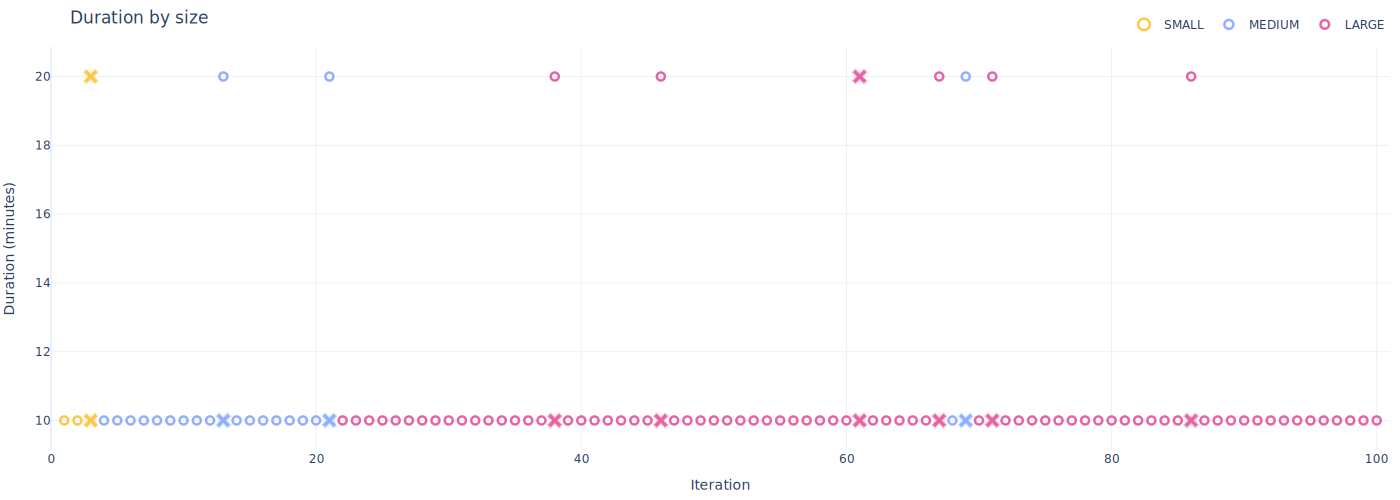

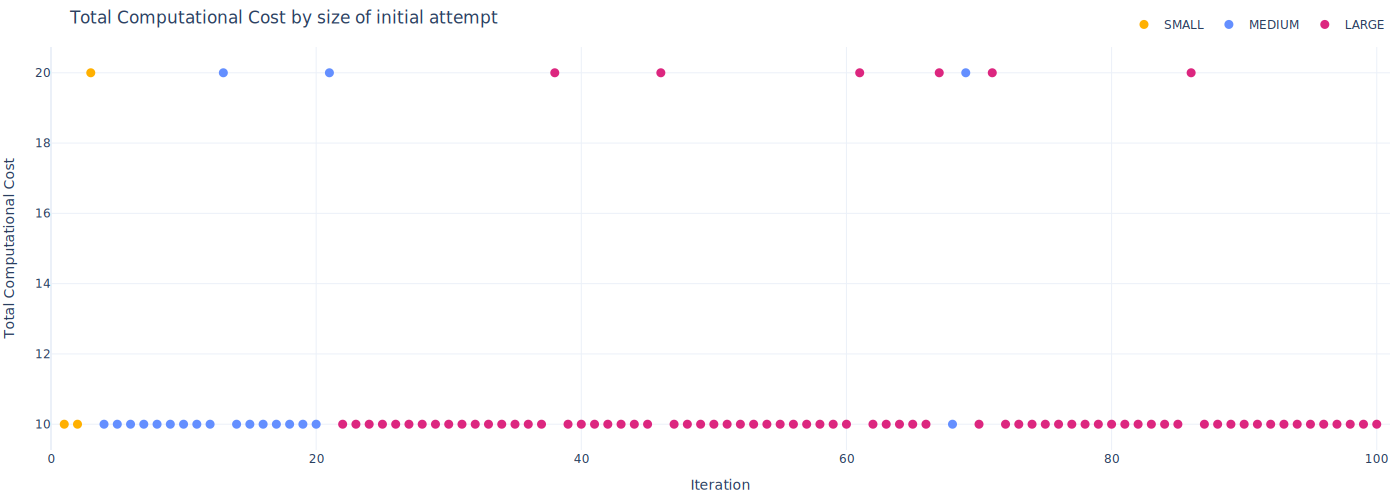

In [12]:
agent = GreedyAgent(INDEPENDENT_WORKERS_CONFIG)
processor = LognormBernoulliProcessor(SUCCESS_RATE_PROCESSOR_CONFIG)
executions = simulate(INDEPENDENT_WORKERS_CONFIG, agent, processor, 100)
plot_duration_by_size(executions).show()
plot_total_cost_by_initial_attempt(executions).show()

# Maximize Success Rate: Epsilon-Greedy 

In [13]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, workers_config, epsilon):
        self.epsilon = epsilon
        self.success_models = {
            s: BernoulliWithBetaPrior(BetaParams(10, 1))
            for s in workers_config
        }
    
    def choose(self) -> Size:
        if bernoulli.rvs(self.epsilon):  # ⬅ Important!
            return Size[np.random.choice(SIZE_NAMES)]
        else:
            params = self.estimate_params()
            scores = self.score_params(params)
            return max(scores, key=scores.get)

    def estimate_params(self):
        return {s: m.estimate_params() for s, m in self.success_models.items()}
        
    def score_params(self, params):
        return {s: param.p for s, param in params.items()}
    
    def observe(self, size: Size, duration: float, success: bool) -> None:
        self.success_models[size].update(np.array([success]))

# Maximize Success Rate: Epsilon-Greedy 

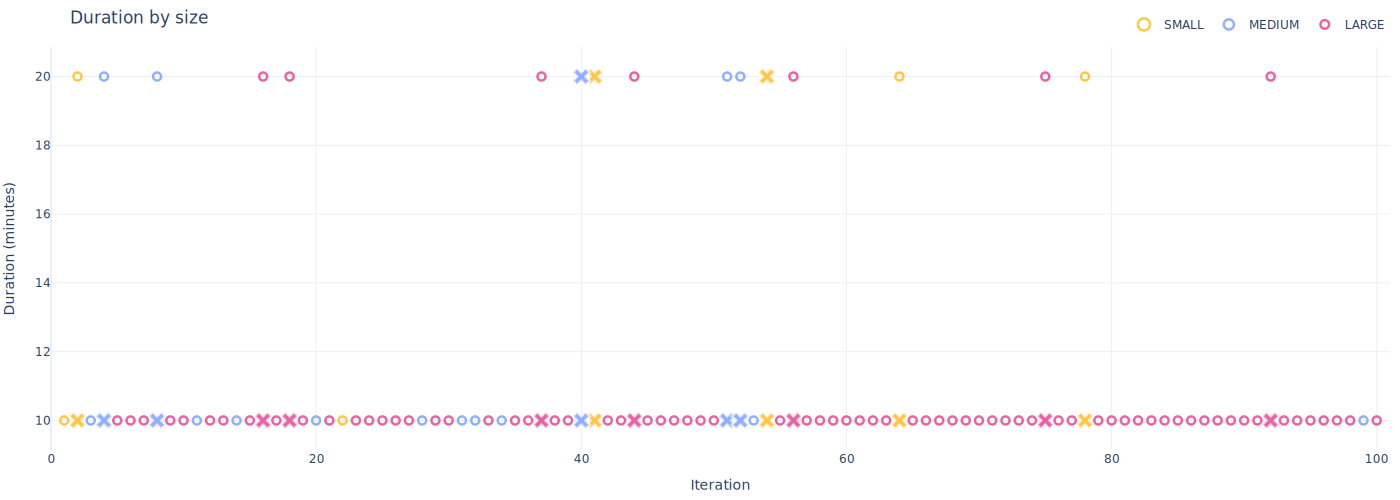

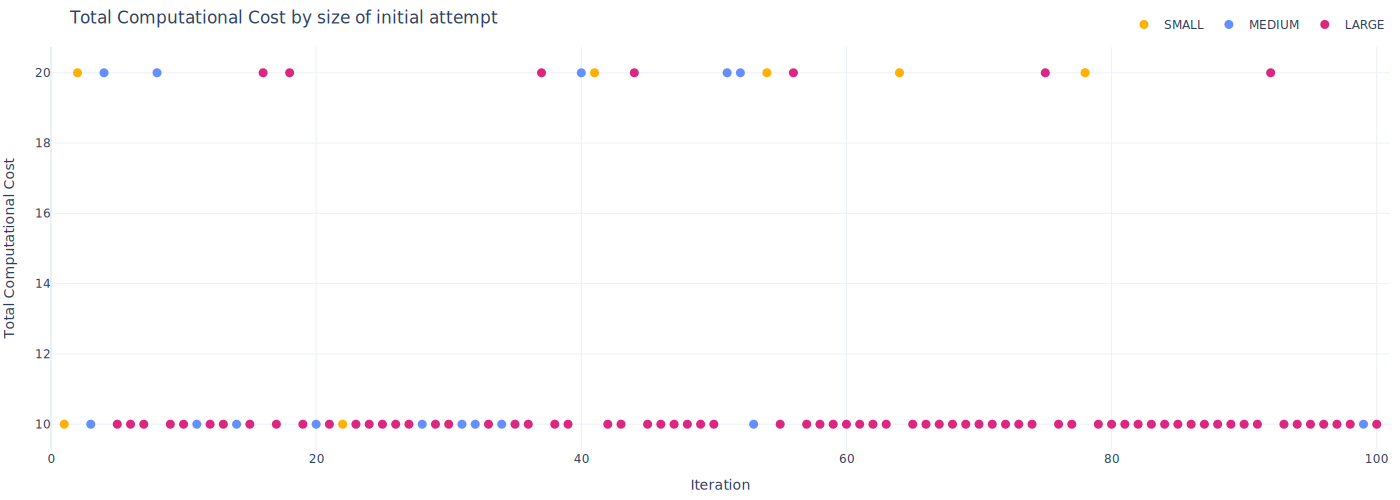

In [14]:
agent = EpsilonGreedyAgent(INDEPENDENT_WORKERS_CONFIG, epsilon=0.3)
processor = LognormBernoulliProcessor(SUCCESS_RATE_PROCESSOR_CONFIG)
executions = simulate(INDEPENDENT_WORKERS_CONFIG, agent, processor, 100)
plot_duration_by_size(executions).show()
plot_total_cost_by_initial_attempt(executions).show()

# Maximize Success Rate: Thompson Sampling

> Thompson sampling is an algorithm for online decision problems where **actions are taken sequentially** in a manner that must balance between **exploiting what is known** to maximize immediate performance and **investing to accumulate new information** that may improve future performance.

> Thompson sampling offers flexible, elegant and efficient approach to exploration in a wide range of **structured decision problems**.


<center><img src="./media/greedy_vs_ts.png" style="float: center;"></center>




[Russo, Daniel J., Benjamin Van Roy, Abbas Kazerouni, Ian Osband, and Zheng Wen. "A tutorial on thompson sampling." Foundations and Trends® in Machine Learning 11, no. 1 (2018): 1-96.](https://www.nowpublishers.com/article/DownloadSummary/MAL-070)

# Maximize Success Rate: Thompson Sampling

In [15]:
class GreedyAgent(Agent):
    def __init__(self, workers_config):
        self.success_models = {
            s: BernoulliWithBetaPrior(BetaParams(2, 2))
            for s in workers_config
        }
    
    def choose(self) -> Size:
        params = self.estimate_params()  # ⬅ Important!
        scores = self.score_params(params)
        return max(scores, key=scores.get)

    def estimate_params(self):
        return {
            s: m.estimate_params()
            for s, m in self.success_models.items()
        }
        
    def score_params(self, params):
        return {s: param.p for s, param in params.items()}
    
    def observe(self, size, duration, success):
        self.success_models[size].update(np.array([success]))

In [16]:
class SuccessRateTSAgent(Agent):
    def __init__(self, workers_config):
        self.success_models = {
            s: BernoulliWithBetaPrior(BetaParams(2, 2))
            for s in workers_config
        }
    
    def choose(self) -> Size:
        params = self.sample_params()  # ⬅ Important!
        scores = self.score_params(params)
        return max(scores, key=scores.get)
        
    def sample_params(self):
        return {
            s: m.sample_params()
            for s, m in self.success_models.items()
        }
        
    def score_params(self, params):
        return {s: param.p for s, param in params.items()}
    
    def observe(self, size, duration, success):
        self.success_models[size].update(np.array([success]))

In [17]:
class SuccessRateTSAgentWithReporting(SuccessRateTSAgent):
    def report(self):
        return {
            name: value
            for s, model in self.success_models.items()
            for name, value in [
                (f"success_hparams_{s.value}", model.hparams),
                (f"success_mean_{s.value}", beta.mean(**asdict(model.hparams))),
                (f"success_lower_{s.value}", beta.ppf(0.10, **asdict(model.hparams))),
                (f"success_upper_{s.value}", beta.ppf(0.90, **asdict(model.hparams))),
            ]
        }

# Maximize Success Rate: Thompson Sampling

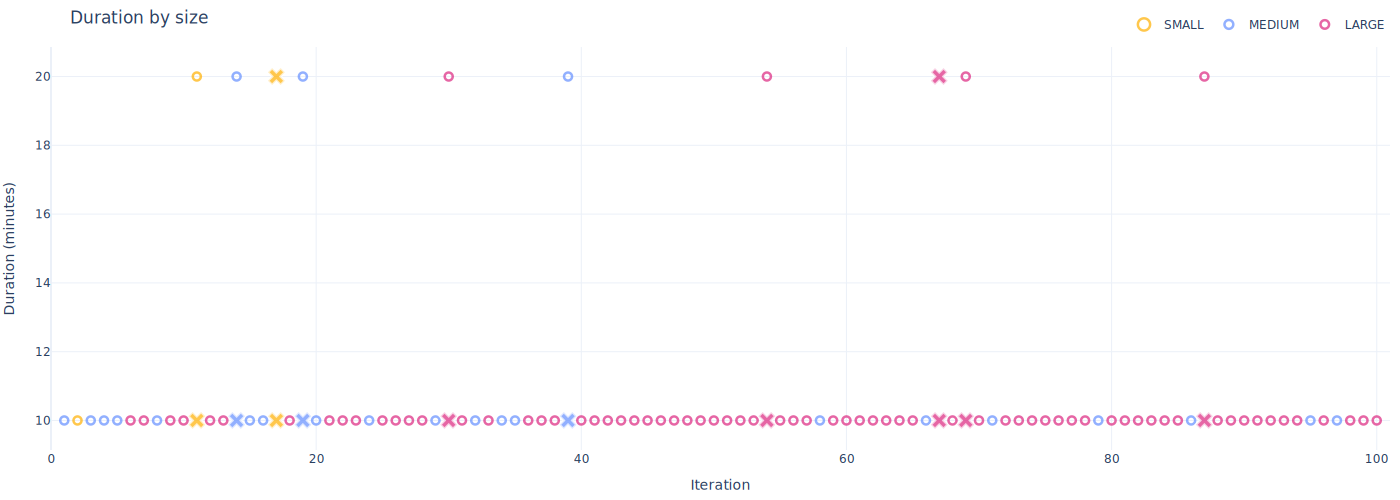

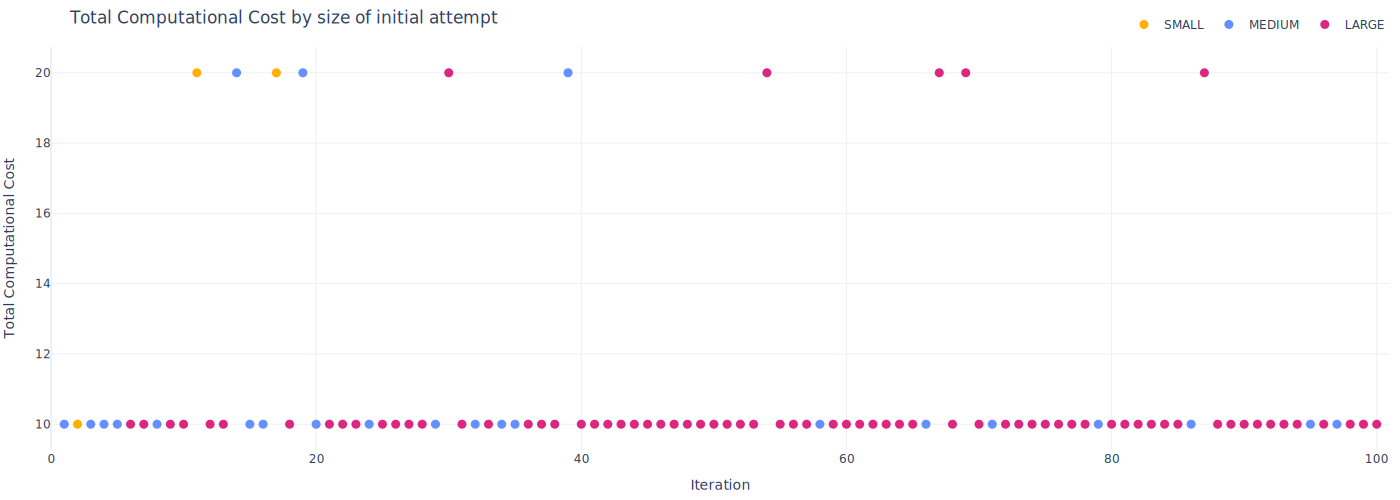

In [18]:
agent = SuccessRateTSAgentWithReporting(INDEPENDENT_WORKERS_CONFIG)
processor = LognormBernoulliProcessor(SUCCESS_RATE_PROCESSOR_CONFIG)
executions = simulate(INDEPENDENT_WORKERS_CONFIG, agent, processor, 100, seed=10)
plot_duration_by_size(executions).show()
plot_total_cost_by_initial_attempt(executions).show()

In [19]:
def plot_success_dist(df):
    if df.size == 0:
        return
    
    fig = (
        df.iloc[[-1], :]
        .pipe(pd.wide_to_long, 
            stubnames=["success_hparams"],
            i=["iteration"],
            j='size',
            sep="_",
            suffix='.+',
        )
        .loc[:, ["success_hparams"]]
        .assign(
            x = lambda df: [np.linspace(0, 1.0, 100) for _ in range(df.shape[0])]
        )
        .assign(
            y = lambda df: [
                beta.pdf(r.x, r.success_hparams.a, r.success_hparams.b)
                for r in df.to_records()
            ] 
        )
        .explode(["x", "y"])
        .reset_index()
        .pipe(
            px.line,
            x="x",
            y="y",
            color="size",
        color_discrete_map=SIZE_COLORS)
    )

    fig.update_layout(
        **default_layout,
        title="Success probability density function by size",
        yaxis_title=None,
        xaxis_title=None,
        xaxis_range=[0, 1],
    )
    fig.update_yaxes(rangemode="tozero")
    return fig




def plot_success_confidence(df):  
    # https://plotly.com/python/continuous-error-bars/

    # Select only one row per iteration
    df = df[df["total_cost"].notna() | (df["iteration"] == 0)]
        
    fig = go.Figure()

    for size in [Size.S, Size.M, Size.L]:
        fig.add_trace(
            go.Scatter(
                name=size.value,
                mode='lines',
                x=df["iteration"],
                y=df[f"success_mean_{size.value}"],
                marker=dict(
                     color=SIZE_COLORS[size],
                ),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=df["iteration"],
                y=df[f"success_upper_{size.value}"],
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                hoverinfo="skip",
                opacity=0.1,
            ),
        )
        fig.add_trace(
            go.Scatter(
                name=size.value,
                x=df["iteration"],
                y=df[f"success_lower_{size.value}"],
                line=dict(width=0),
                mode='lines',
                fill='tonexty',
                fillcolor=SIZE_COLORS_TRANSPARENT[size],
                showlegend=not CLASSIC,
                hoverinfo="skip",
            )
        )
        
    fig.update_layout(
        **default_layout,
        title="Success probability with confidence bounds",
        xaxis_range=[0, 101],
        yaxis_range=[0, 1],
        showlegend=True,
    )
 
    return fig

# Maximize Success Rate: Thompson Sampling

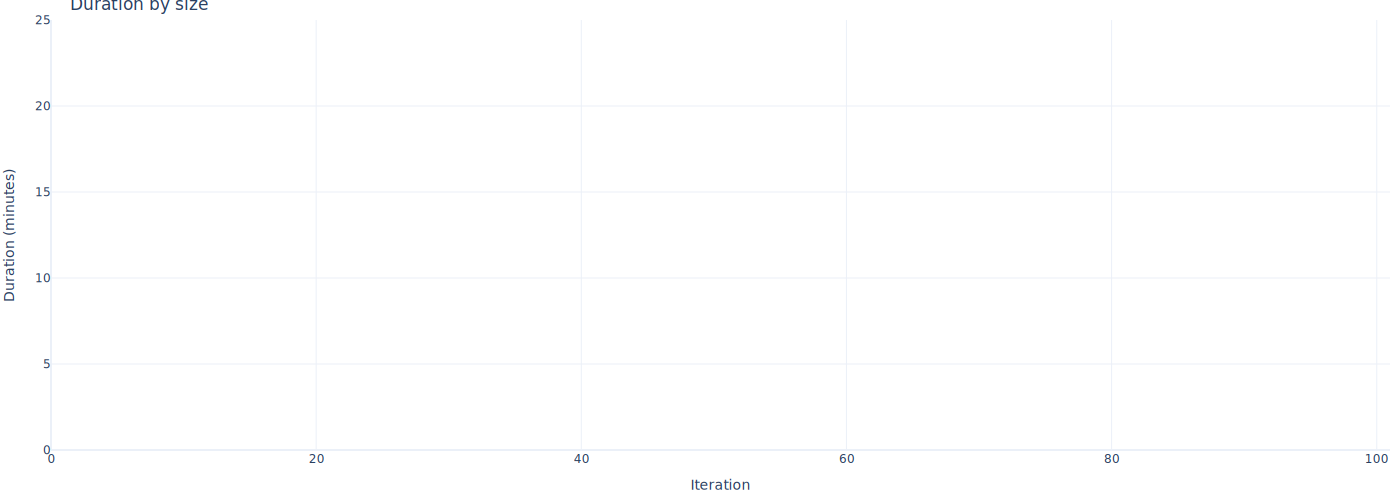

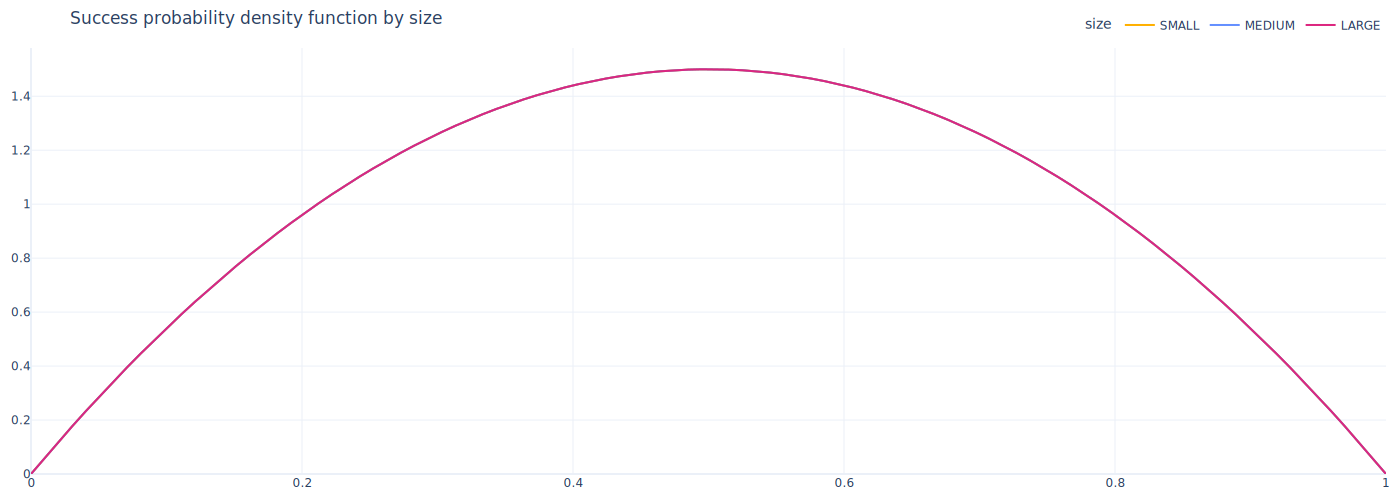

In [20]:
frame = 1
plot_duration_by_size(executions[:frame]).update_layout(yaxis_range=[0, 25]).show()
plot_success_dist(executions[:frame]).show()

# Maximize Success Rate: Thompson Sampling

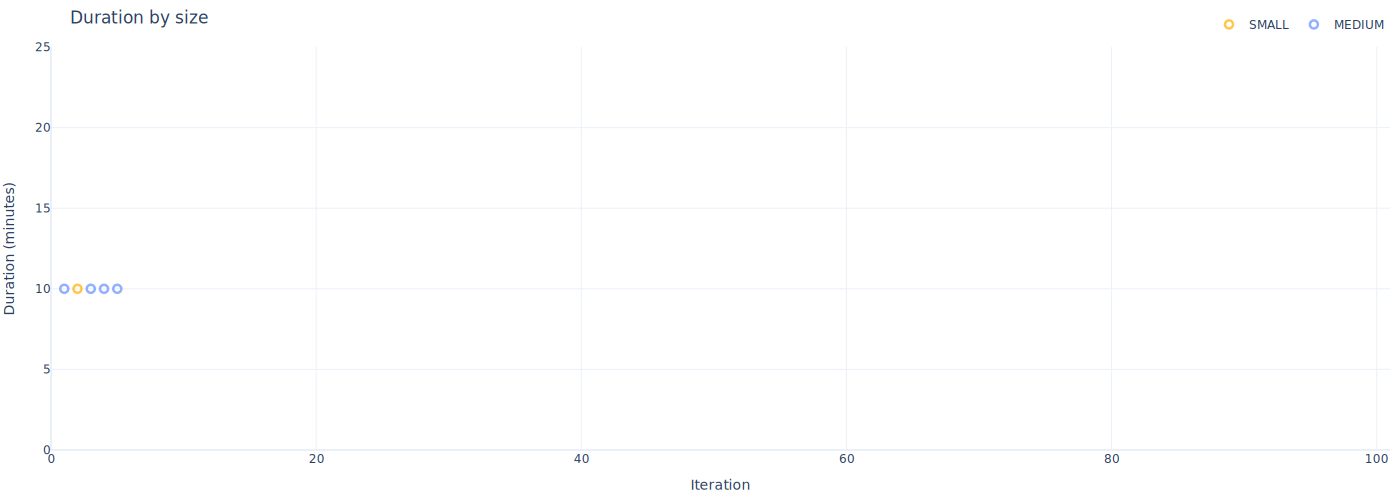

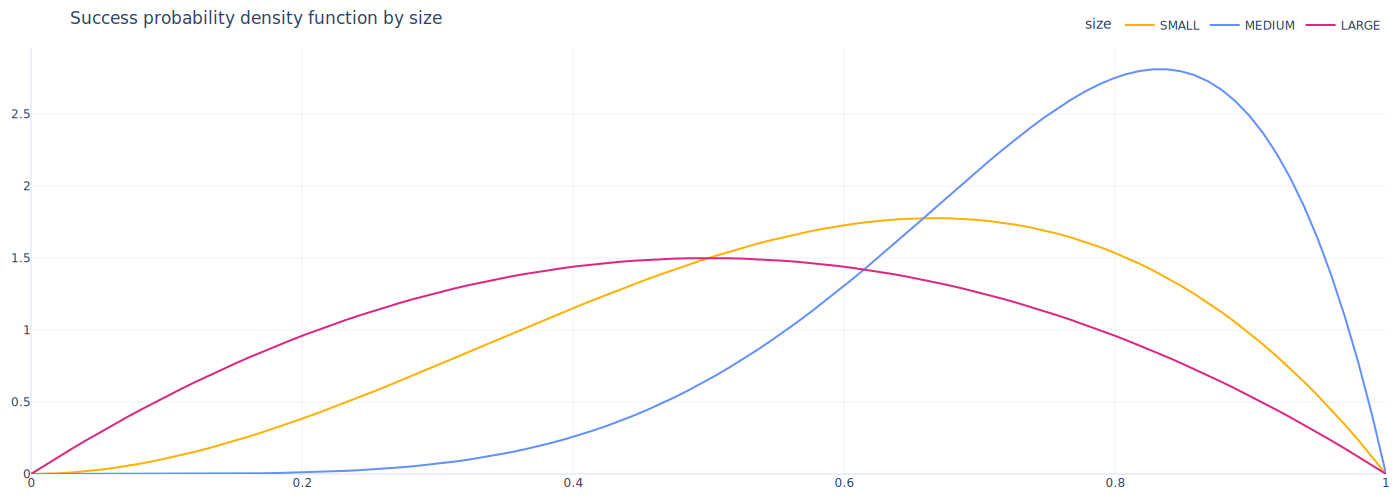

In [21]:
frame = 6
plot_duration_by_size(executions[:frame]).update_layout(yaxis_range=[0, 25]).show()
plot_success_dist(executions[:frame]).show()

# Maximize Success Rate: Thompson Sampling

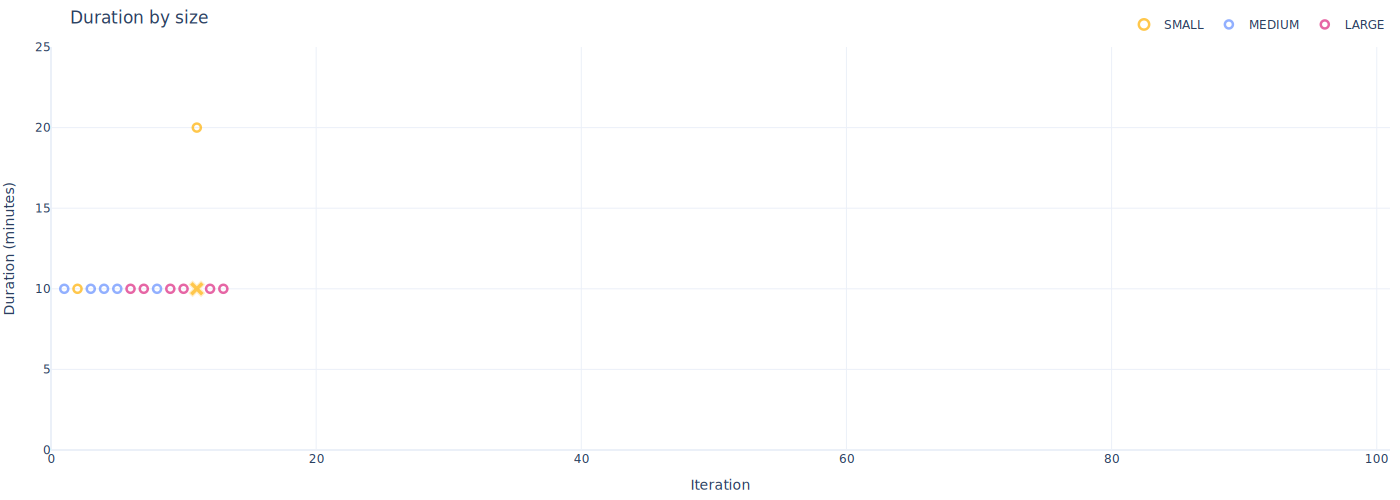

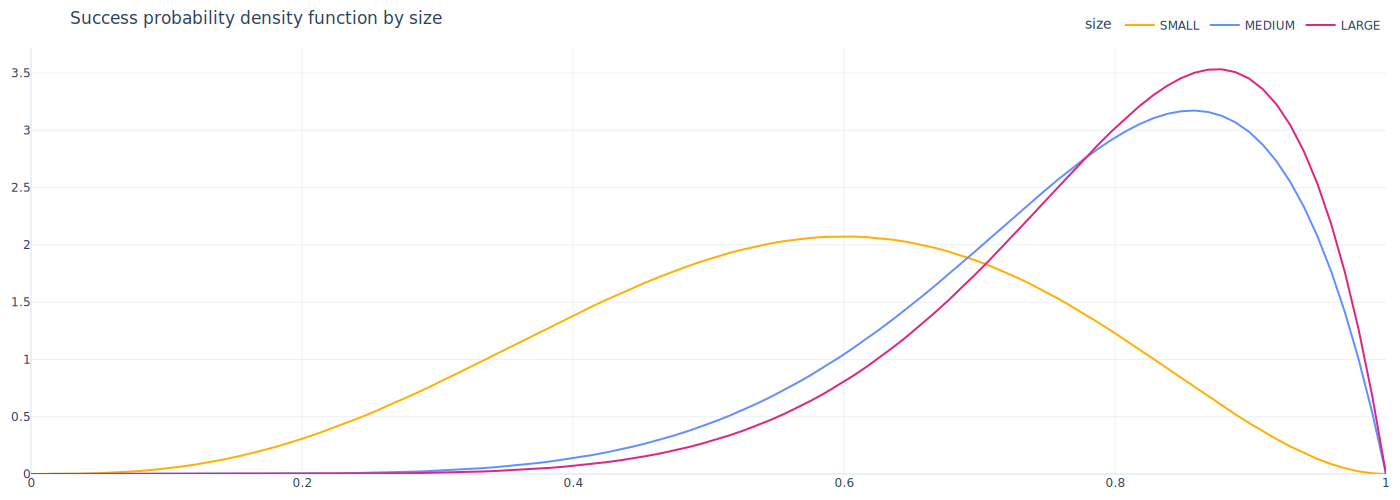

In [22]:
frame = 15
plot_duration_by_size(executions[:frame]).update_layout(yaxis_range=[0, 25]).show()
plot_success_dist(executions[:frame]).show()

# Maximize Success Rate: Thompson Sampling

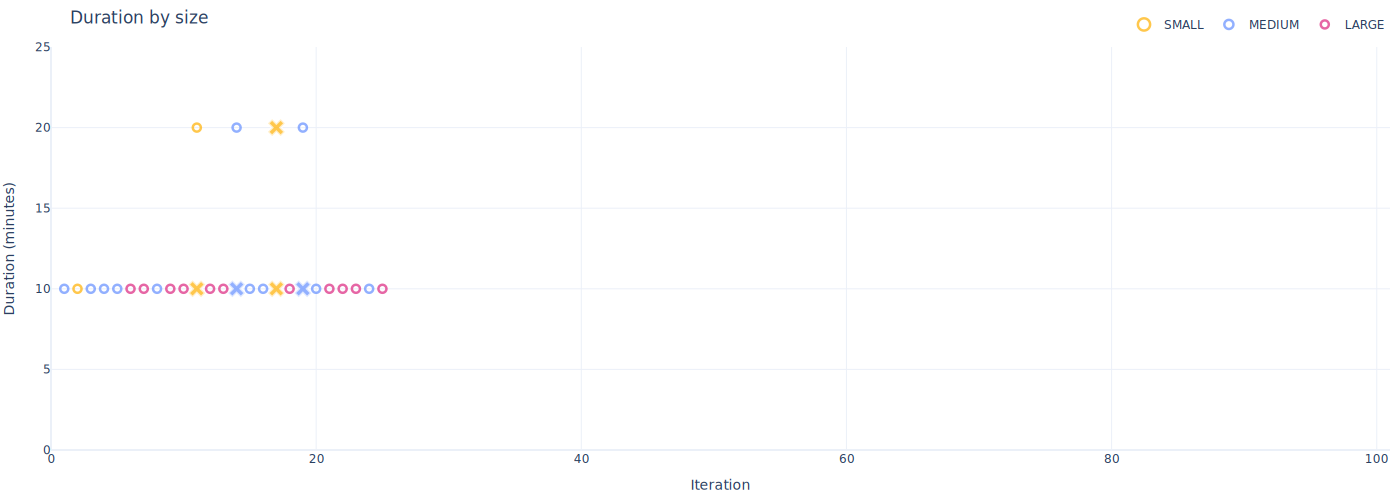

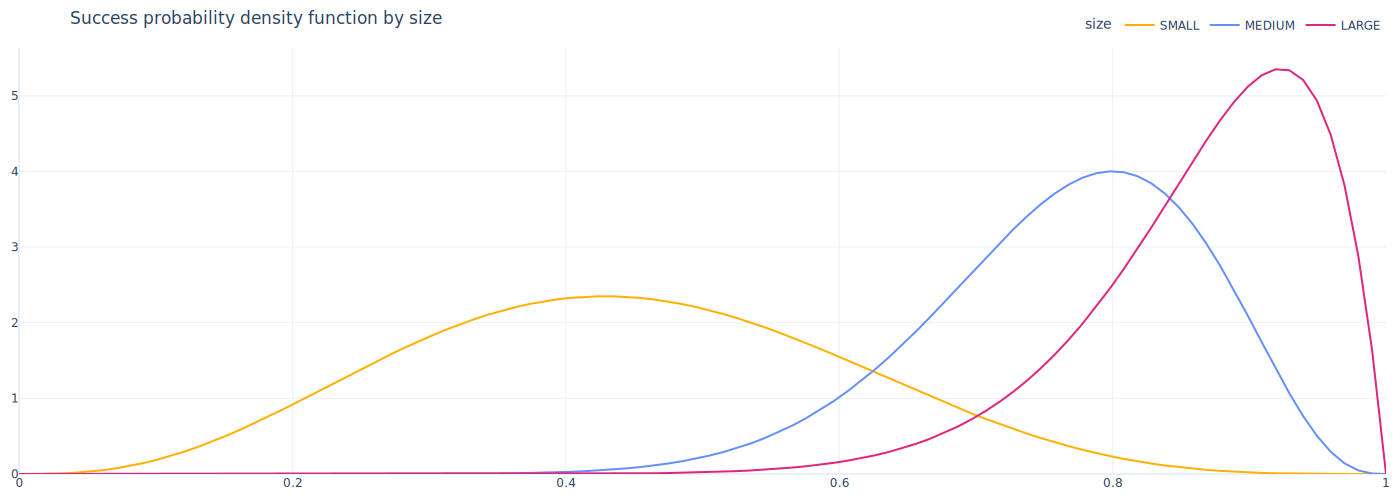

In [23]:
frame = 30
plot_duration_by_size(executions[:frame]).update_layout(yaxis_range=[0, 25]).show()
plot_success_dist(executions[:frame]).show()

# Maximize Success Rate: Thompson Sampling

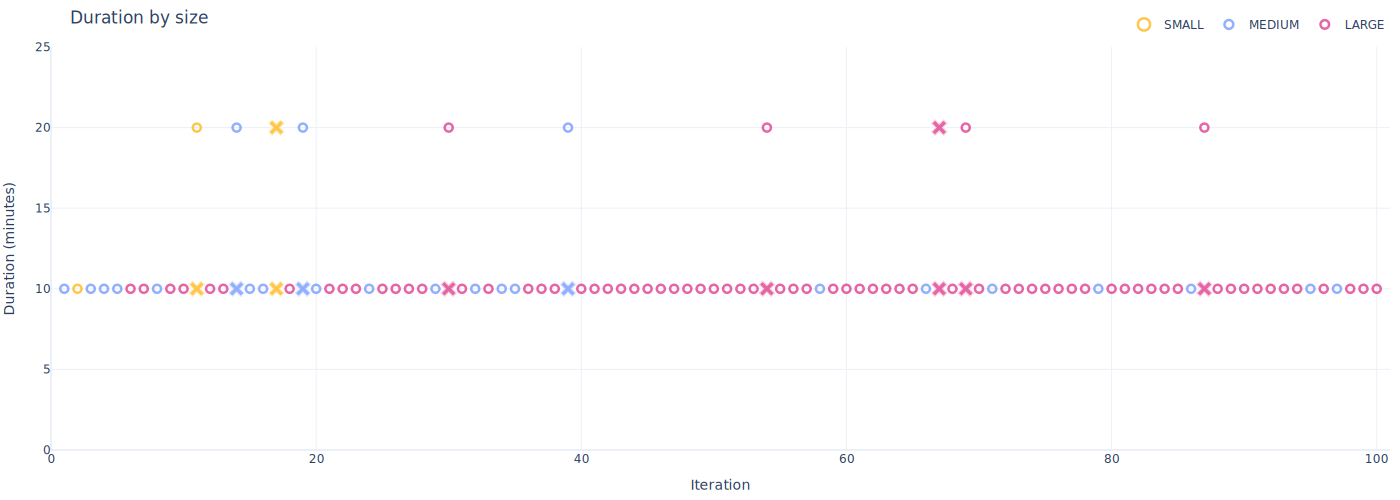

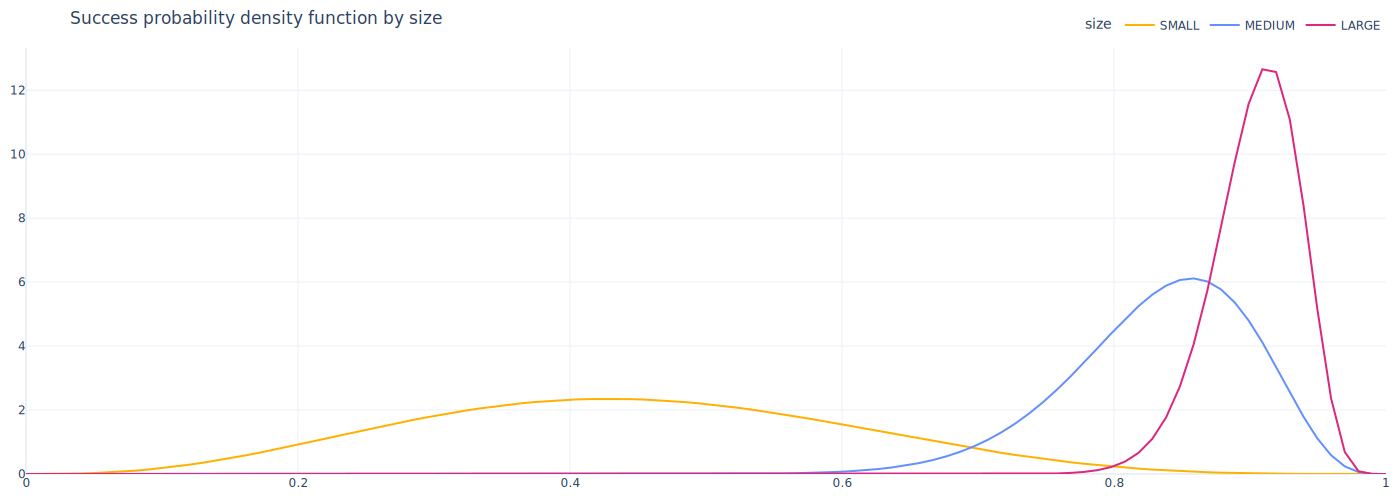

In [24]:
plot_duration_by_size(executions).update_layout(yaxis_range=[0, 25]).show()
plot_success_dist(executions).show()

# Maximize Success Rate: Thompson Sampling

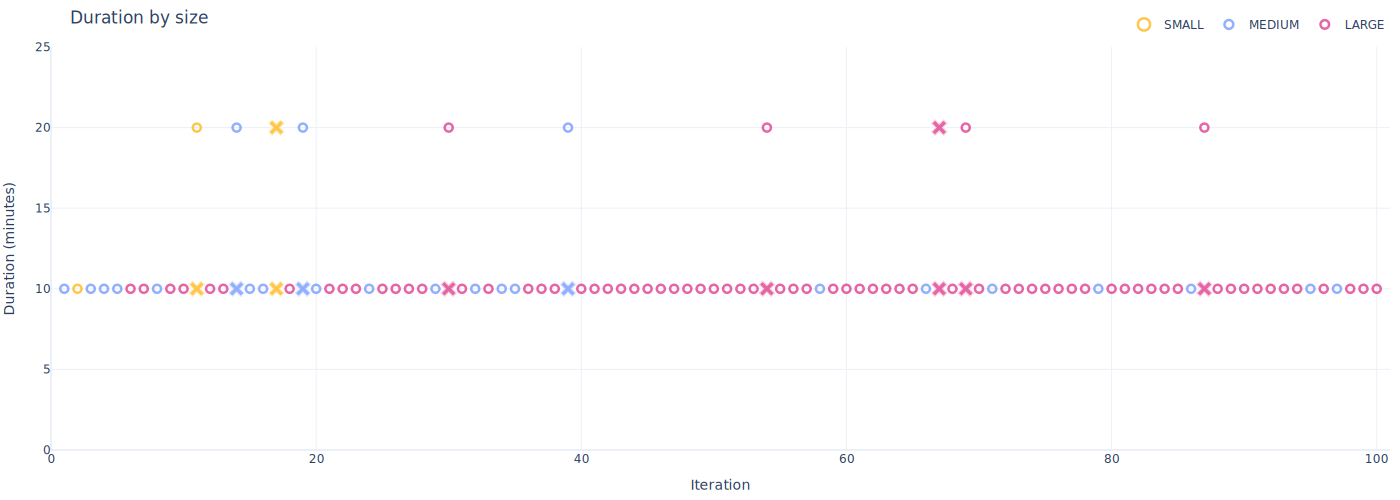

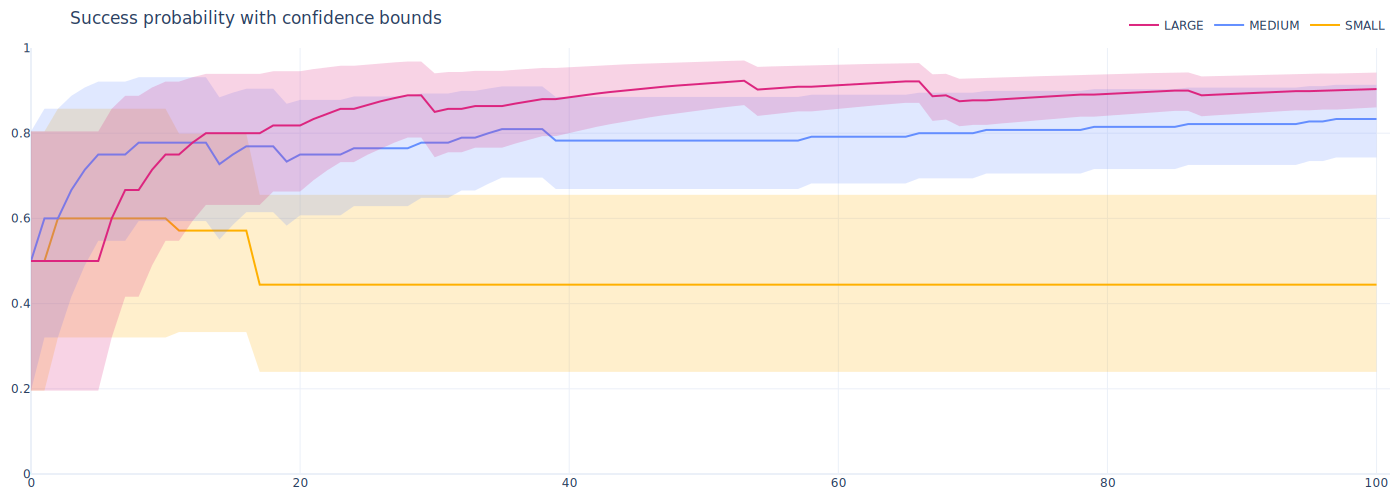

In [25]:
plot_duration_by_size(executions).update_layout(yaxis_range=[0, 25]).show()
plot_success_confidence(executions).show()

# Minimize Total Computational Cost: Objective

> *Computational Cost of the first attempt and all the subsequent retries*.

$$
\mathbb{E}[total\_computational\_cost(t, w)] = \\ \mathbb{E}[duration(t, w)] \cdot cost(w) \\
+ (1 - \mathbb{E}[success(t, w)]) \\
\cdot \mathbb{E}[total\_computational\_cost(t, next(w))]
$$

Statistical model:

$$
ln(duration) \sim \mathcal{N}(\mu,\,\sigma^{2})
$$
$$
success \sim Bernoulli(p)
$$

Considers:
- Duration
- Success rate
- Cost of workers
- Retry rules


# Minimize Total Computational Cost: Model

In [26]:
from scipy.stats import norm, gamma

@dataclass
class NormParams:
    mu: float
    tau: float

@dataclass
class NormalGammaParams:
    alpha: float
    beta: float
    mu0: float
    n0: float

# https://en.wikipedia.org/wiki/Conjugate_prior
class NormWithNormalGammaPrior:
    def __init__(self, prior: NormalGammaParams):
        self.hparams = prior

    def update(self, x: np.ndarray) -> None:
        alpha, beta, mu0, n0 = astuple(self.hparams)
        n = np.size(x)
        x_avg = np.mean(x)
        x_var = np.sum(np.square(x - x_avg)) / n

        new_alpha = alpha + n / 2
        new_beta = beta + n * x_var / 2 + (n * n0) * np.square(x_avg - mu0) / (2 * (n + n0))
        new_mu0 = (n * x_avg + n0 * mu0)/ (n + n0)
        new_n0 = n0 + n

        self.hparams = NormalGammaParams(new_alpha, new_beta, new_mu0, new_n0)
        
    def sample_params(self) -> BernoulliParams:
        alpha, beta, mu0, n0 = astuple(self.hparams)

        tau = gamma.rvs(alpha, scale=1 / beta)
        mu = norm.rvs(loc=mu0, scale=np.sqrt(1 / (n0 * tau)))

        return NormParams(mu, tau)
    
    def estimate_params(self) -> BernoulliParams:
        alpha, beta, mu0, n0 = astuple(self.hparams)

        tau = gamma.mean(alpha, scale=1 / beta)
        mu = norm.mean(loc=mu0, scale=np.sqrt(1 / (n0 * tau)))
        
        return NormParams(mu, tau)
    
    def sample_values(self) -> bool:
        params = self.sample_params()
        return norm.rvs(loc=params.mu, scale=np.sqrt(1 / params.tau))


<center><img src="./media/NormWithNormalGammaPrior.png" style="float: center;"></center>

# Minimize Total Computational Cost: Expected Value

In [27]:
def calculate_total_computational_cost(
    workers_config: List[WorkerConfig],  # Sorted topologically!
    success_params: BetaParams,
    duration_params: NormParams,
):
    total_cost = {}
    for worker in reversed(workers_config):
        p_success = success_params[worker.size].p
        duration_mean = np.exp(
            duration_params[worker.size].mu + 
            1 / (2 * duration_params[worker.size].tau)
        )
        
        # Limit exploration of workers with low success rates.
        if p_success < 0.8:
            p_success = 0.1

        # Cost of the first attempt.
        cost_initial_attempt = worker.cost * duration_mean

        # Cost of retrying failed task possibly on a larger worker.
        total_cost_retry = (
            total_cost[worker.succ]
            if worker.succ is not None
            else cost_initial_attempt
        )

        total_cost[worker.size] = cost_initial_attempt + (1 - p_success) * total_cost_retry

    return total_cost

# Minimize Total Computational Cost: Thompson Sampling

In [28]:
class TotalcalComputationalCostTSAgent(Agent):
    def __init__(self, workers_config):
        self.workers_config = workers_config
        self.success_models = {
            s: BernoulliWithBetaPrior(BetaParams(1, 1))
            for s in workers_config
        }
        self.duration_models = {
            s: NormWithNormalGammaPrior(NormalGammaParams(2.0, 1.0, np.log(10), 1))
            for s in workers_config
        }
    
    def choose(self):
        params = self.sample_params()
        scores = self.score_params(params)
        return min(scores, key=scores.get)
    
    def sample_params(self):
        return (
            {s: model.sample_params() for s, model in self.success_models.items()},
            {s: model.sample_params() for s, model in self.duration_models.items()},
        )
    
    def observe(self, size, duration, success):
        self.success_models[size].update(np.array([success]))       
        self.duration_models[size].update(np.array([np.log(duration)]))
        
    def score_params(self, params):
        success_params, duration_params = params
        return calculate_total_computational_cost(
            self.workers_config.values(),
            success_params,
            duration_params,
        )

In [29]:
class TotalComputationalCostTSAgentWithReporting(TotalcalComputationalCostTSAgent):
    def report(self):
        scores = [agent.score_params(agent.sample_params()) for _ in range(200)]
        return {
            name: value
            for s in self.workers_config
            for name, value in [
                (f"total_cost_mean_{s.value}", np.mean([x[s] for x in scores])),
                (f"total_cost_lower_{s.value}", np.percentile(np.array([x[s] for x in scores]), 10)),
                (f"total_cost_upper_{s.value}", np.percentile(np.array([x[s] for x in scores]), 90)),
            ]
        }

# Minimize Total Computational Cost: Thompson Sampling

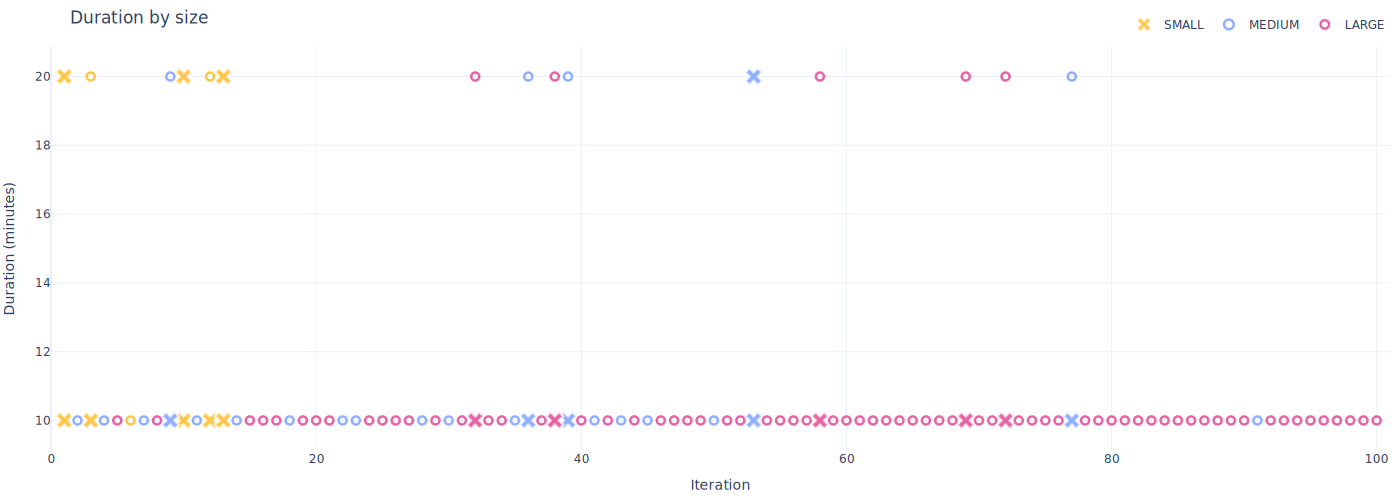

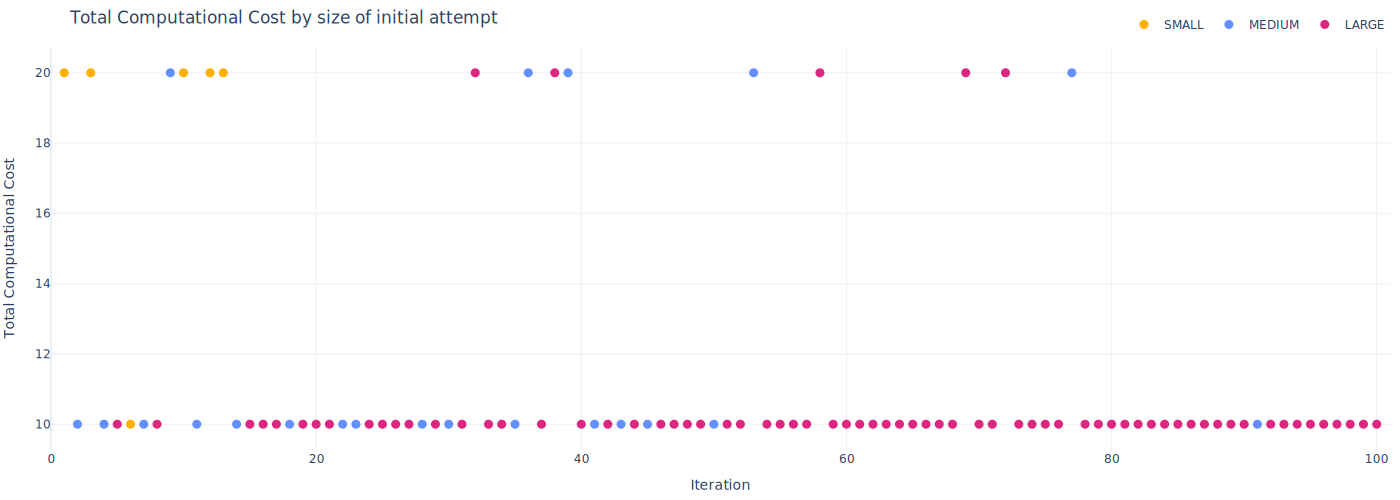

In [30]:
agent = TotalcalComputationalCostTSAgent(INDEPENDENT_WORKERS_CONFIG)
processor = LognormBernoulliProcessor(SUCCESS_RATE_PROCESSOR_CONFIG)
executions = simulate(INDEPENDENT_WORKERS_CONFIG, agent, processor, 100, seed=10)
plot_duration_by_size(executions).show()
plot_total_cost_by_initial_attempt(executions).show()

# Minimize Total Computational Cost: Thompson Sampling

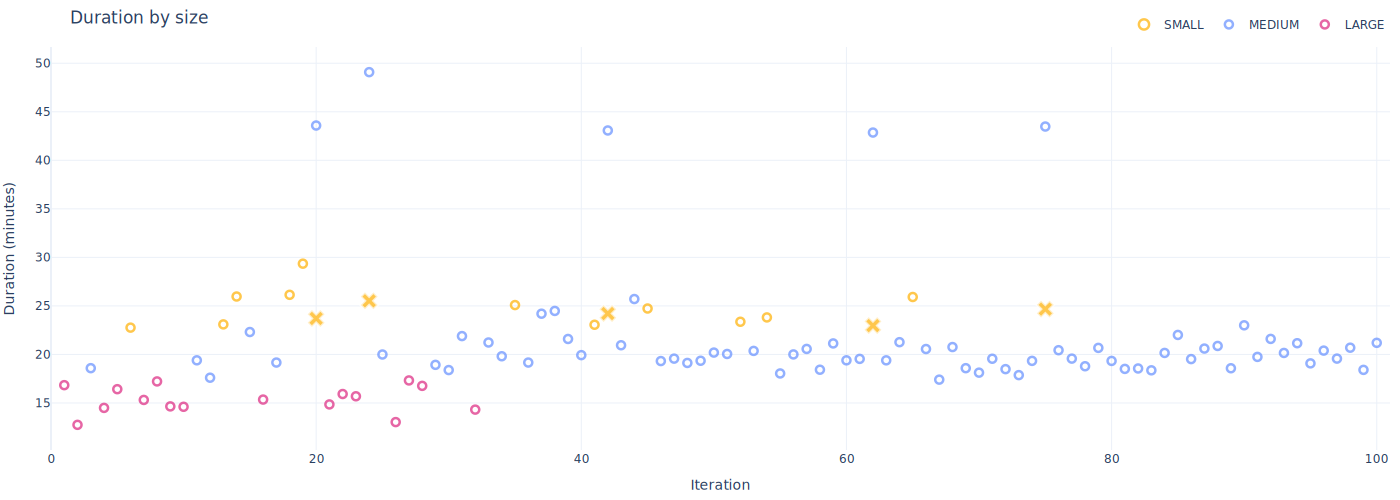

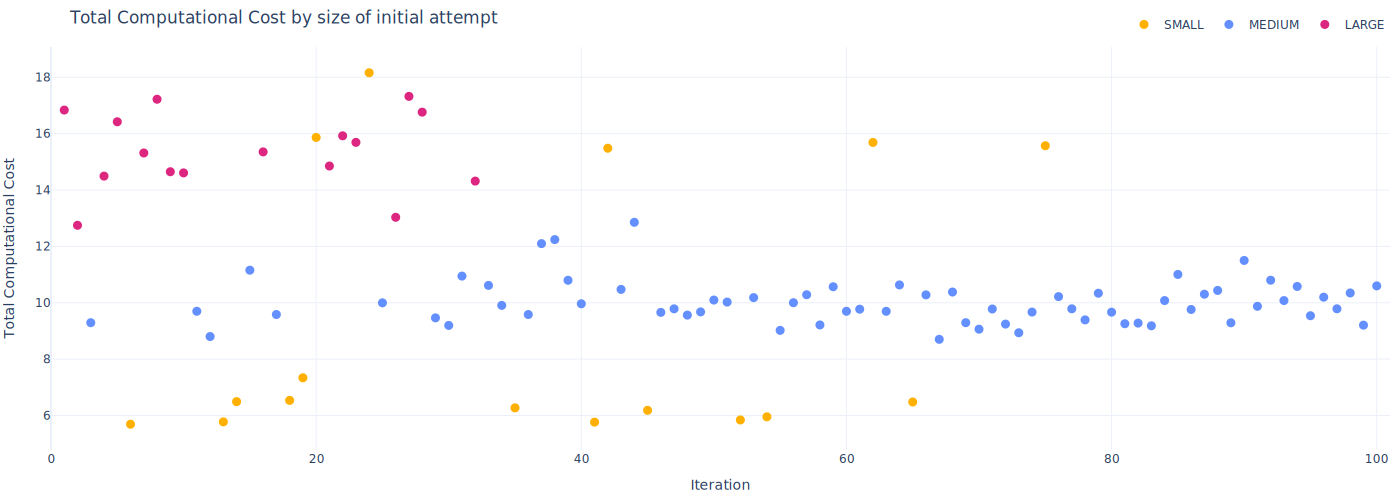

In [31]:
agent = TotalComputationalCostTSAgentWithReporting(WORKERS_CONFIG)
processor = LognormBernoulliProcessor(PROCESSOR_CONFIG)
executions = simulate(WORKERS_CONFIG, agent, processor, 100, seed=10)
plot_duration_by_size(executions).show()
plot_total_cost_by_initial_attempt(executions).show()

# Minimize Total Computational Cost: Thompson Sampling

In [32]:
def plot_total_cost_confidence(df):  
    # https://plotly.com/python/continuous-error-bars/

    # Select only one row per iteration
    df = df[df["total_cost"].notna() | (df["iteration"] == 0)]
        
    fig = go.Figure()

    for size in [Size.S, Size.M, Size.L]:
        fig.add_trace(
            go.Scatter(
                name=size.value,
                mode='lines',
                x=df["iteration"],
                y=df[f"total_cost_mean_{size.value}"],
                marker=dict(
                     color=SIZE_COLORS[size],
                ),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=df["iteration"],
                y=df[f"total_cost_upper_{size.value}"],
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                hoverinfo="skip",
                opacity=0.1,
            ),
        )
        fig.add_trace(
            go.Scatter(
                name=size.value,
                x=df["iteration"],
                y=df[f"total_cost_lower_{size.value}"],
                line=dict(width=0),
                mode='lines',
                fill='tonexty',
                fillcolor=SIZE_COLORS_TRANSPARENT[size],
                showlegend=not CLASSIC,
                hoverinfo="skip",
            )
        )
        
    fig.update_layout(
        **default_layout,
        title="Total Computational Cost estimate with confidence bounds",
        xaxis_range=[0, 101],
        xaxis_title="Iteration",
        yaxis_title="Total Computational Cost",
        showlegend=True,
    )
 
    return fig

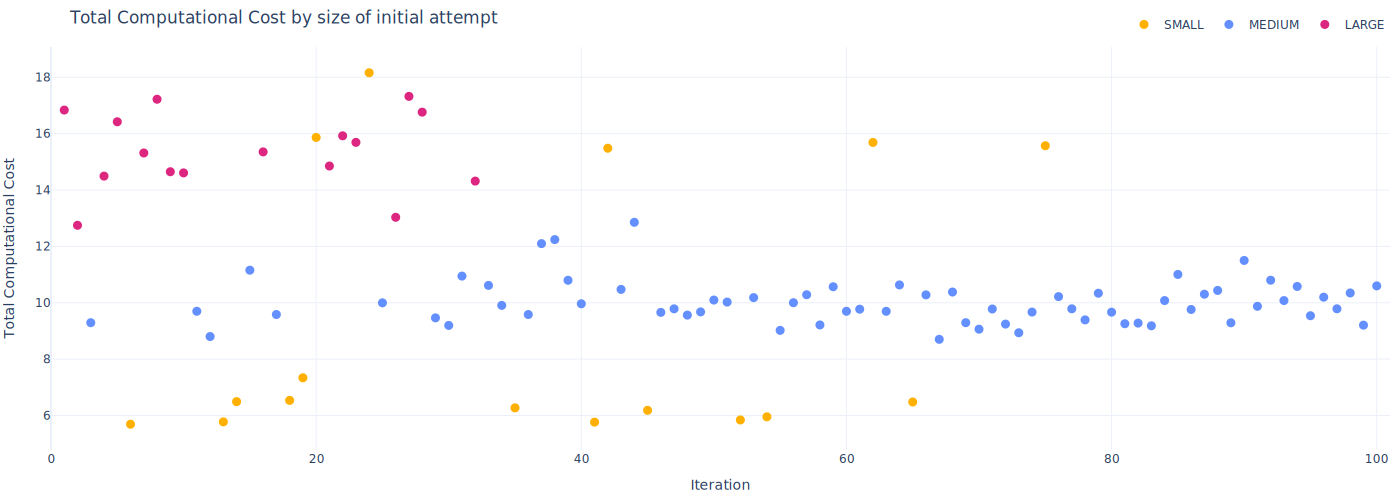

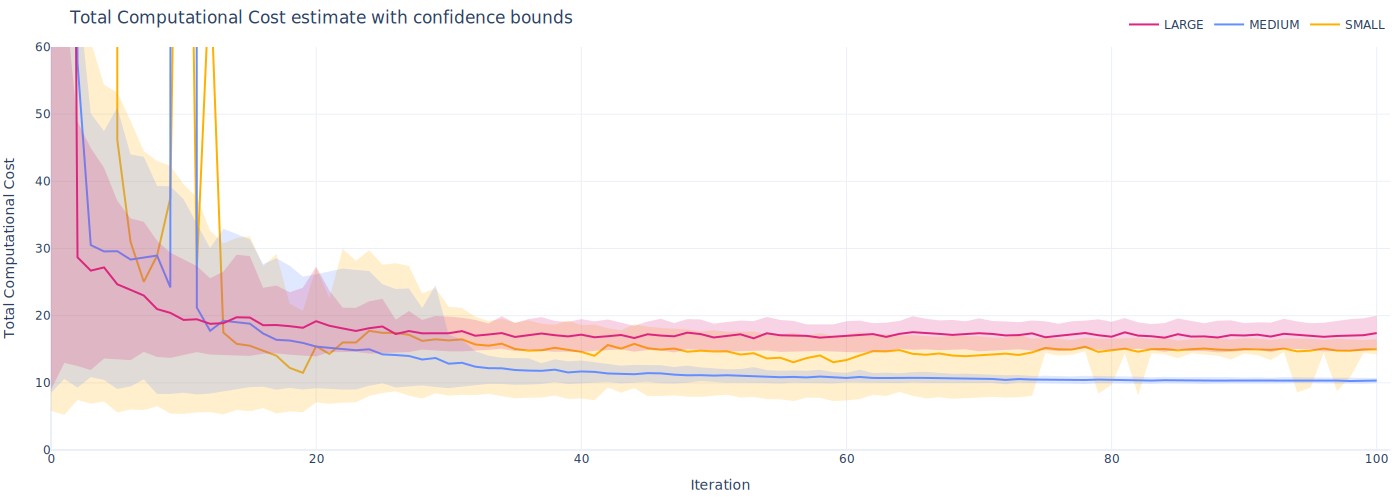

In [33]:
plot_total_cost_by_initial_attempt(executions).show()
plot_total_cost_confidence(executions).update_layout( yaxis_range=[0, 60]).show()

# Practical Considerations

- **Souce of entropy** - stochastic algorithms require good sources of entropy.
   - Use good soruce of entropy to generate seed and save it in task definition.
- **Nonstationary systems** - success rate can change over time.
   - Ignore historical observations made beyond N time periods in the past.
- **Conditional dependency** - duration depends on the outcome.
   - Use different models for success and failure outcomes.
- **Unnecessary exploration** - if task keeps failing on M there is no point in exploring S.
   - Allow the model to only explore sizes neighboring to the current best size.
- **Multidimensional problem space** - workers differ on more than one dimension.
   - Switch from a list to a graph of options using successor relationship.
- **Shared state** - results of initial attempt can be partially cached.
   - Allow agent to observe results only from the initial attempt.
- **Dynamic contexts** - task identifier changes over time.
   - Use a hierarchy of tasks and fallback if the number of observations is low
- **Conflicting objectives** - some tasks should optimize for speed.
   - Create a way to override allocation decisions.

# Summary

- Greedy algorithms are vulnerable to tasks which consume all the allocated resources.
- Resource allocation module should optimize for the Total Computational Cost defined as the cost of the first attempt and all the subsequent retries.
- Thompson Sampling algorithm offer asymptotically optimal solutions to the problem of minimizing Total Computational Cost. Its efficient approach to exploration in structured decision problems makes it a great fit for complex retry rules.

<center><img style="width: 30%; height: auto;" src="./media/queues.png" style="float: center;"></center>

# Resouces

1. [Russo, Daniel J., Benjamin Van Roy, Abbas Kazerouni, Ian Osband, and Zheng Wen. "A tutorial on thompson sampling." Foundations and Trends® in Machine Learning 11, no. 1 (2018): 1-96.](https://www.nowpublishers.com/article/DownloadSummary/MAL-070)
2. [Marmerola G.D., "Introduction to Thompson Sampling: the Bernoulli bandit" (2017)](https://gdmarmerola.github.io/ts-for-bernoulli-bandit/)
3. [Jordan, Michael I. "The conjugate prior for the normal distribution." Lecture notes on Stat260: Bayesian Modeling and Inference (2010).](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf)